In [1]:
import os
import torch
import wandb
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from torch.utils.data import Dataset, DataLoader

D:\Downloads\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_dem = pd.read_excel('dataset/Telco_customer_churn_demographics.xlsx')
df_loc = pd.read_excel('dataset/Telco_customer_churn_location.xlsx')
df_pop = pd.read_excel('dataset/Telco_customer_churn_population.xlsx')
df_ser = pd.read_excel('dataset/Telco_customer_churn_services.xlsx')
df_sta = pd.read_excel('dataset/Telco_customer_churn_status.xlsx')

# Dataset overview
Our dataset is information from 7043 customer.
More information: https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [3]:
print('Demographics dataset: {} rows x {} columns'.format(*df_dem.shape))
print('Location dataset: {} rows x {} columns'.format(*df_loc.shape))
print('Population dataset: {} rows x {} columns'.format(*df_pop.shape))
print('Services dataset: {} rows x {} columns'.format(*df_ser.shape))
print('Status dataset: {} rows x {} columns'.format(*df_sta.shape))

Demographics dataset: 7043 rows x 9 columns
Location dataset: 7043 rows x 10 columns
Population dataset: 1671 rows x 3 columns
Services dataset: 7043 rows x 30 columns
Status dataset: 7043 rows x 11 columns


## Status dataset
We will analysis each column of this dataset

In [4]:
df_sta

,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges
...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,Q3,5,Stayed,No,0,45,5306,NaN,NaN
7039,6840-RESVB,1,Q3,3,Stayed,No,0,59,2140,NaN,NaN
7040,2234-XADUH,1,Q3,4,Stayed,No,0,71,5560,NaN,NaN
7041,4801-JZAZL,1,Q3,4,Stayed,No,0,59,2793,NaN,NaN


In [5]:
len(df_sta['Customer ID'].unique())

7043

### Column Count and Quarter
These columns have only one value, so we can skip these columns for analysing later

In [6]:
df_sta['Count'].unique(), df_sta['Quarter'].unique()

(array([1], dtype=int64), array(['Q3'], dtype=object))

### Satisfaction Score
All of customers which have churn value = 0 have satisfaction score 3-5, others which have churn value = 1 have satisfaction score 1-3

In [7]:
df = pd.crosstab(df_sta['Satisfaction Score'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Satisfaction Score,,,
1,0,922,100.000000
2,0,518,100.000000
3,2236,429,16.100000
4,1789,0,0.000000
5,1149,0,0.000000


### Customer Status
Customer have three status, with 'joined' status and 'stayed' status always have churned value equal to 0, 'churned' status always have 1 churned value

In [8]:
pd.crosstab(df_sta['Customer Status'], df_sta['Churn Value']).style.background_gradient(cmap='Blues')

Churn Value,0,1
Customer Status,,
Churned,0,1869
Joined,454,0
Stayed,4720,0


### Churn label
This dataset is unbalance that numbers of churned label 0 is three time of numbers of churned label 1

In [9]:
pd.crosstab(df_sta['Churn Label'], df_sta['Churn Value']).style.background_gradient(cmap='Blues')

Churn Value,0,1
Churn Label,,
No,5174,0
Yes,0,1869


### Churn Score distribution
all customers with churn value 0 have churn score 5-80, others with churn value 1 have churn score 50-96

In [10]:
def churn_score(x):
    if 5<=x<=49:
        return '5-49'
    if 50<=x<=80:
        return '50-80'
    if 81<=x<=96:
        return '81-96'
df_sta['Churn Score range'] = df_sta['Churn Score'].apply(lambda x: churn_score(x))
df = pd.crosstab(df_sta['Churn Score range'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Churn Score range,,,
5-49,2533,0,0.000000
50-80,2641,805,23.360000
81-96,0,1064,100.000000


### CLTV Distribution
Churned customer ratio reduce as CLTV increase

In [11]:
df_sta['CLTV range'] = df_sta.apply(lambda row: {
    2: '2001-3000',
    3: '3001-4000',
    4: '4001-5000',
    5: '5001-6000',
    6: '6001-7000',
}[(row['CLTV']-1)//1000], axis=1)

In [12]:
df = pd.crosstab(df_sta['CLTV range'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
CLTV range,,,
2001-3000,759,423,35.790000
3001-4000,798,389,32.770000
4001-5000,1598,504,23.980000
5001-6000,1631,515,24.000000
6001-7000,388,38,8.920000


### Churn Category with Churn Reason
Most of chured reasons is about support attitude and better competitor

In [13]:
pd.crosstab(df_sta['Churn Reason'], df_sta['Churn Category']).style.background_gradient(cmap='Blues')

Churn Category,Attitude,Competitor,Dissatisfaction,Other,Price
Churn Reason,,,,,
Attitude of service provider,94,0,0,0,0
Attitude of support person,220,0,0,0,0
Competitor had better devices,0,313,0,0,0
Competitor made better offer,0,311,0,0,0
Competitor offered higher download speeds,0,100,0,0,0
Competitor offered more data,0,117,0,0,0
Deceased,0,0,0,6,0
Don't know,0,0,0,130,0
Extra data charges,0,0,0,0,39


## Demographics dataset
We will analysis each column of this dataset

In [14]:
df_dem

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1
...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,Female,30,No,No,No,No,0
7039,6840-RESVB,1,Male,38,No,No,Yes,Yes,2
7040,2234-XADUH,1,Female,30,No,No,Yes,Yes,2
7041,4801-JZAZL,1,Female,32,No,No,Yes,Yes,2


### Gender
Gender is even distributed by both churned customers and not-churned customers

In [15]:
df = pd.crosstab(df_dem['Gender'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Gender,,,
Female,2549,939,26.920000
Male,2625,930,26.160000


### Age
High-age custermers have very high churned ratio, with 61-70 customer have 32% churned, and 71-80 customers have 41% churned

In [16]:
df_dem['Age range'] = df_dem['Age'].apply(lambda x: {
    1: '19-20',
    2: '21-30',
    3: '31-40',
    4: '41-50',
    5: '51-60',
    6: '61-70',
    7: '71-80',
}[(x-1)//10])
df = pd.crosstab(df_dem['Age range'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Age range,,,
19-20,206,48,18.900000
21-30,981,294,23.060000
31-40,985,303,23.520000
41-50,1003,309,23.550000
51-60,943,309,24.680000
61-70,642,313,32.770000
71-80,414,293,41.440000


### Under 30

In [17]:
df_dem['Age range 2'] = df_dem['Age'].apply(lambda x: '19-29' if x<30 else '30-80')
pd.crosstab(df_dem['Age range 2'], df_dem['Under 30']).style.background_gradient(cmap='Blues')

Under 30,No,Yes
Age range 2,,
19-29,0,1401
30-80,5642,0


In [18]:
df = pd.crosstab(df_dem['Under 30'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Under 30,,,
No,4077,1565,27.740000
Yes,1097,304,21.700000


### Senior Citizen

In [19]:
df_dem['Age range 3'] = df_dem['Age'].apply(lambda x: '19-64' if x<65 else '65-80')
pd.crosstab(df_dem['Age range 3'], df_dem['Senior Citizen']).style.background_gradient(cmap='Blues')

Senior Citizen,No,Yes
Age range 3,,
19-64,5901,0
65-80,0,1142


In [20]:
df = pd.crosstab(df_dem['Senior Citizen'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Senior Citizen,,,
No,4508,1393,23.610000
Yes,666,476,41.680000


### Married
Married customers even distributed in all age range, around 50%, with 71-80 age range have highest married ratio

In [21]:
df = pd.crosstab(df_dem['Age range'], df_dem['Married'])
df['Yes percent'] = (df['Yes'] / (df['Yes'] + df['No']) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Married,No,Yes,Yes percent
Age range,,,
19-20,135,119,46.850000
21-30,637,638,50.040000
31-40,653,635,49.300000
41-50,704,608,46.340000
51-60,660,592,47.280000
61-70,513,442,46.280000
71-80,339,368,52.050000


About 2/3 of churned customers are unmarried, and chunred rate of unmarried customers is about 33% higher than married customers

In [22]:
df = pd.crosstab(df_dem['Married'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Married,,,
No,2441,1200,32.960000
Yes,2733,669,19.660000


### Dependents
Dependents reduce to 16% at age range 61-70, and 7% at age range 71-80

In [23]:
df = pd.crosstab(df_dem['Age range'], df_dem['Dependents'])
df['Yes percent'] = (df['Yes'] / (df['Yes'] + df['No']) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Dependents,No,Yes,Yes percent
Age range,,,
19-20,182,72,28.350000
21-30,948,327,25.650000
31-40,931,357,27.720000
41-50,968,344,26.220000
51-60,938,314,25.080000
61-70,794,161,16.860000
71-80,655,52,7.360000


About 94% churned customers have no dependents, and no-dependents customers have 5 times higher churned ratio than dependents customers

In [24]:
df = pd.crosstab(df_dem['Dependents'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Dependents,,,
No,3653,1763,32.550000
Yes,1521,106,6.520000


### Number of Dependents

Number of Dependents even distributed over age range 21-30, 31-40, 41-50 and 51-60

In [25]:
pd.crosstab(df_dem['Age range'], df_dem['Number of Dependents']).style.background_gradient(cmap='Blues')

Number of Dependents,0,1,2,3,4,5,6,7,8,9
Age range,,,,,,,,,,
19-20,182,21,31,20,0,0,0,0,0,0
21-30,948,106,112,106,0,2,0,0,0,1
31-40,931,129,106,113,3,4,0,1,1,0
41-50,968,107,115,114,5,2,0,1,0,0
51-60,938,99,99,113,0,1,2,0,0,0
61-70,794,61,54,43,1,1,1,0,0,0
71-80,655,30,14,8,0,0,0,0,0,0


In [26]:
df = pd.crosstab(df_dem['Number of Dependents'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Number of Dependents,,,
0,3653,1763,32.550000
1,515,38,6.870000
2,498,33,6.210000
3,487,30,5.800000
4,8,1,11.110000
5,8,2,20.000000
6,2,1,33.330000
7,1,1,50.000000
8,1,0,0.000000


## Location dataset

In [27]:
df_loc

,Location ID,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude
0,OXCZEW7397,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.023810,-118.156582
1,FCCECI8494,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237
2,HEHUQY7254,1658-BYGOY,1,United States,California,Los Angeles,90065,"34.108833, -118.229715",34.108833,-118.229715
3,WIUHRF2613,4598-XLKNJ,1,United States,California,Inglewood,90303,"33.936291, -118.332639",33.936291,-118.332639
4,CFEZBF4415,4846-WHAFZ,1,United States,California,Whittier,90602,"33.972119, -118.020188",33.972119,-118.020188
...,...,...,...,...,...,...,...,...,...,...
7038,XVCVGG7664,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416
7039,NOTKAT3139,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183
7040,IIQJBU2929,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164
7041,PBNAHR7564,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330


### Column Count and Country and State
These columns have only one value, so we can skip these columns for analysing later

In [28]:
df_loc.Count.unique(), df_loc.Country.unique(), df_loc.State.unique()

(array([1], dtype=int64),
 array(['United States'], dtype=object),
 array(['California'], dtype=object))

### City
We have total 1106 different cities

In [29]:
len(df_loc.City.unique())

1106

### Zip Code
We have total 1625 different zip codes

In [30]:
len(df_loc['Zip Code'].unique())

1625

### Lat Long

The left figure is the location of churned customers, the right figure is the location of not churned customers

In [31]:
def visualize(x_churn, y_churn, x_not_churn, y_not_churn):
    # plt.figure(figsize=(6.4*2, 4.8*2), dpi=100)
    # plt.scatter(cus_lngs, cus_lats, c=color_ordered, marker=',')
    plt.subplot(2, 2, 1)
    plt.scatter(y_churn, x_churn, s=1, c='red', marker=',')
    plt.subplot(2, 2, 2)
    plt.scatter(y_not_churn, x_not_churn, s=1, c='blue', marker=',')

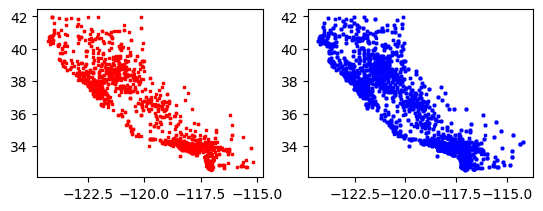

In [32]:
visualize(df_loc[df_sta['Churn Value']==1]['Latitude'], df_loc[df_sta['Churn Value']==1]['Longitude'], df_loc[df_sta['Churn Value']==0]['Latitude'], df_loc[df_sta['Churn Value']==0]['Longitude'])

## Population dataset

In [33]:
df_pop

,ID,Zip Code,Population
0,1,90001,54492
1,2,90002,44586
2,3,90003,58198
3,4,90004,67852
4,5,90005,43019
...,...,...,...
1666,1667,96145,4002
1667,1668,96146,942
1668,1669,96148,678
1669,1670,96150,33038


## Services dataset

In [34]:
df_ser

,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,1,Q3,No,0,1,None,No,0.00,No,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,Q3,No,0,72,None,Yes,22.77,No,...,No,Two Year,Yes,Bank Withdrawal,21.15,1419.40,19.31,0,1639.44,3039.53
7039,6840-RESVB,1,Q3,Yes,1,24,Offer C,Yes,36.05,Yes,...,Yes,One Year,Yes,Mailed Check,84.80,1990.50,48.23,0,865.20,2807.47
7040,2234-XADUH,1,Q3,Yes,4,72,None,Yes,29.66,Yes,...,Yes,One Year,Yes,Credit Card,103.20,7362.90,45.38,0,2135.52,9453.04
7041,4801-JZAZL,1,Q3,Yes,1,11,None,No,0.00,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,29.60,346.45,27.24,0,0.00,319.21


### Column Count and Quarter
These columns have only one value, so we can skip these columns for analysing later

In [35]:
df_ser['Count'].unique(), df_ser['Quarter'].unique()

(array([1], dtype=int64), array(['Q3'], dtype=object))

### Referred a Friend
Referred customers even distributed in all age range, around 46%

In [36]:
df = pd.crosstab(df_dem['Age range'], df_ser['Referred a Friend'])
df['Yes percent'] = (df['Yes'] / (df['Yes'] + df['No']) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Referred a Friend,No,Yes,Yes percent
Age range,,,
19-20,140,114,44.880000
21-30,670,605,47.450000
31-40,694,594,46.120000
41-50,731,581,44.280000
51-60,690,562,44.890000
61-70,531,424,44.400000
71-80,365,342,48.370000


This 'refer' column seem similar to column 'married', with about 2/3 of churned customer have no referred, and chunred rate of no-referred customer is about 33% higher than referred customer

In [37]:
df = pd.crosstab(df_ser['Referred a Friend'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Referred a Friend,,,
No,2576,1245,32.580000
Yes,2598,624,19.370000


Surprise! 'Referred a Friend' column is almost the same as married column

In [38]:
pd.crosstab(df_ser['Referred a Friend'], df_dem['Married']).style.background_gradient(cmap='Blues')

Married,No,Yes
Referred a Friend,,
No,3641,180
Yes,0,3222


### Number of Referrals

In [39]:
pd.crosstab(df_dem['Age range'], df_ser['Number of Referrals']).style.background_gradient(cmap='Blues')

Number of Referrals,0,1,2,3,4,5,6,7,8,9,10,11
Age range,,,,,,,,,,,,
19-20,140,39,7,11,4,13,8,10,8,4,10,0
21-30,670,182,48,45,55,56,43,41,42,54,39,0
31-40,694,196,42,51,45,41,39,46,36,47,51,0
41-50,731,192,43,46,37,57,40,49,38,40,38,1
51-60,690,178,31,47,47,40,46,44,42,47,39,1
61-70,531,162,37,27,28,31,31,28,29,27,24,0
71-80,365,137,28,28,20,26,14,30,18,19,22,0


In [40]:
pd.crosstab(df_ser['Number of Referrals'], df_sta['Churn Value']).style.background_gradient(cmap='Blues')

Churn Value,0,1
Number of Referrals,,
0,2576,1245
1,579,507
2,210,26
3,223,32
4,218,18
5,243,21
6,213,8
7,242,6
8,211,2


### Tenure in Months
Most of churned customers have 'tenure in months' from 1-12 (new customers), and reduce as the tenure in months increasing.
Most of not-churnedd customers have been with companies > 5 years

In [41]:
df_ser['Tenure in Months range'] = df_ser['Tenure in Months'].apply(lambda x: {
    0: '1-12',
    1: '13-24',
    2: '25-36',
    3: '41-48',
    4: '51-60',
    5: '61-72',
}[(x-1)//12])
df = pd.crosstab(df_ser['Tenure in Months range'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Tenure in Months range,,,
1-12,1149,1037,47.440000
13-24,730,294,28.710000
25-36,652,180,21.630000
41-48,617,145,19.030000
51-60,712,120,14.420000
61-72,1314,93,6.610000


### Offer
Most churned customers have no offer and offer E, and the better offer, the number of churned customers lower.
Customers have offer E have so-high churned rate, even twice times as whom with no offer, so I suggest that we should remove offer E

In [42]:
df = pd.crosstab(df_ser['Offer'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Offer,,,
None,2826,1051,27.110000
Offer A,485,35,6.730000
Offer B,723,101,12.260000
Offer C,320,95,22.890000
Offer D,441,161,26.740000
Offer E,379,426,52.920000


### Phone Service

In [43]:
df = pd.crosstab(df_ser['Phone Service'], df_sta['Churn Value'])
df['1 percent'] = (df[1] / (df[0] + df[1]) * 100).round(2)
df.style.background_gradient(cmap='Blues')

Churn Value,0,1,1 percent
Phone Service,,,
No,512,170,24.930000
Yes,4662,1699,26.710000


# Data preprocessing

## Demographics dataset

In [44]:
df_dem_input = df_dem[['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents']]
df_dem_input

,Customer ID,Gender,Age,Married,Number of Dependents
0,8779-QRDMV,Male,78,No,0
1,7495-OOKFY,Female,74,Yes,1
2,1658-BYGOY,Male,71,No,3
3,4598-XLKNJ,Female,78,Yes,1
4,4846-WHAFZ,Female,80,Yes,1
...,...,...,...,...,...
7038,2569-WGERO,Female,30,No,0
7039,6840-RESVB,Male,38,Yes,2
7040,2234-XADUH,Female,30,Yes,2
7041,4801-JZAZL,Female,32,Yes,2


## Location dataset and Population dataset

In [45]:
df_loc = pd.merge(df_loc, df_pop, on=['Zip Code'], how='left')
df_loc_input = df_loc[['Customer ID', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Population']]
df_loc_input

,Customer ID,City,Zip Code,Latitude,Longitude,Population
0,8779-QRDMV,Los Angeles,90022,34.023810,-118.156582,68701
1,7495-OOKFY,Los Angeles,90063,34.044271,-118.185237,55668
2,1658-BYGOY,Los Angeles,90065,34.108833,-118.229715,47534
3,4598-XLKNJ,Inglewood,90303,33.936291,-118.332639,27778
4,4846-WHAFZ,Whittier,90602,33.972119,-118.020188,26265
...,...,...,...,...,...,...
7038,2569-WGERO,Landers,92285,34.341737,-116.539416,2182
7039,6840-RESVB,Adelanto,92301,34.667815,-117.536183,18980
7040,2234-XADUH,Amboy,92304,34.559882,-115.637164,42
7041,4801-JZAZL,Angelus Oaks,92305,34.167800,-116.864330,301


## Services dataset

In [46]:
df_ser_input = df_ser
df_ser_input = df_ser_input.drop(columns=['Count', 'Quarter', 'Referred a Friend', 'Tenure in Months range'])
df_ser_input

,Customer ID,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,0,1,None,No,0.00,No,Yes,DSL,8,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,0,72,None,Yes,22.77,No,No,None,0,...,No,Two Year,Yes,Bank Withdrawal,21.15,1419.40,19.31,0,1639.44,3039.53
7039,6840-RESVB,1,24,Offer C,Yes,36.05,Yes,Yes,Cable,24,...,Yes,One Year,Yes,Mailed Check,84.80,1990.50,48.23,0,865.20,2807.47
7040,2234-XADUH,4,72,None,Yes,29.66,Yes,Yes,Fiber Optic,59,...,Yes,One Year,Yes,Credit Card,103.20,7362.90,45.38,0,2135.52,9453.04
7041,4801-JZAZL,1,11,None,No,0.00,No,Yes,DSL,17,...,Yes,Month-to-Month,Yes,Bank Withdrawal,29.60,346.45,27.24,0,0.00,319.21


## Merge dataset

In [47]:
df_input = pd.merge(df_dem_input, df_loc_input, on=['Customer ID'], how='left')
df_input = pd.merge(df_input, df_ser_input, on=['Customer ID'], how='left')
df_input = pd.merge(df_input, df_sta[['Customer ID', 'Churn Label']], on=['Customer ID'], how='left')
len(df_input)

7043

## Filter out customer status 'joined'

In [48]:
df_input = df_input[df_sta['Customer Status']!='Joined']
len(df_input)

6589

## Drop 'Customer ID' column

In [49]:
df_input = df_input.drop(columns=['Customer ID'])
df_input

,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Population,Number of Referrals,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,Male,78,No,0,Los Angeles,90022,34.023810,-118.156582,68701,0,...,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes
1,Female,74,Yes,1,Los Angeles,90063,34.044271,-118.185237,55668,1,...,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10,Yes
2,Male,71,No,3,Los Angeles,90065,34.108833,-118.229715,47534,0,...,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Yes
3,Female,78,Yes,1,Inglewood,90303,33.936291,-118.332639,27778,1,...,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Yes
4,Female,80,Yes,1,Whittier,90602,33.972119,-118.020188,26265,1,...,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,30,No,0,Landers,92285,34.341737,-116.539416,2182,0,...,Two Year,Yes,Bank Withdrawal,21.15,1419.40,19.31,0,1639.44,3039.53,No
7039,Male,38,Yes,2,Adelanto,92301,34.667815,-117.536183,18980,1,...,One Year,Yes,Mailed Check,84.80,1990.50,48.23,0,865.20,2807.47,No
7040,Female,30,Yes,2,Amboy,92304,34.559882,-115.637164,42,4,...,One Year,Yes,Credit Card,103.20,7362.90,45.38,0,2135.52,9453.04,No
7041,Female,32,Yes,2,Angelus Oaks,92305,34.167800,-116.864330,301,1,...,Month-to-Month,Yes,Bank Withdrawal,29.60,346.45,27.24,0,0.00,319.21,No


## Handle category columns

In [50]:
cat_columns = [column for column, dtype in df_input.dtypes.to_dict().items() if dtype==object]

In [51]:
# cat_columns = df_dem_input.select_dtypes(['category']).columns
df_input[cat_columns] = df_input[cat_columns].apply(lambda x: x.astype('category'))
df_input[cat_columns] = df_input[cat_columns].apply(lambda x: x.cat.codes)
df_input

,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Population,Number of Referrals,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,1,78,0,0,554,90022,34.023810,-118.156582,68701,0,...,0,1,0,39.65,39.65,0.00,20,0.00,59.65,1
1,0,74,1,1,554,90063,34.044271,-118.185237,55668,1,...,0,1,1,80.65,633.30,0.00,0,390.80,1024.10,1
2,1,71,0,3,554,90065,34.108833,-118.229715,47534,0,...,0,1,0,95.45,1752.55,45.61,0,203.94,1910.88,1
3,0,78,1,1,448,90303,33.936291,-118.332639,27778,1,...,0,1,0,98.50,2514.50,13.43,0,494.00,2995.07,1
4,0,80,1,1,1072,90602,33.972119,-118.020188,26265,1,...,0,1,0,76.50,2868.15,0.00,0,234.21,3102.36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,30,0,0,514,92285,34.341737,-116.539416,2182,0,...,2,1,0,21.15,1419.40,19.31,0,1639.44,3039.53,0
7039,1,38,1,2,2,92301,34.667815,-117.536183,18980,1,...,1,1,2,84.80,1990.50,48.23,0,865.20,2807.47,0
7040,0,30,1,2,22,92304,34.559882,-115.637164,42,4,...,1,1,1,103.20,7362.90,45.38,0,2135.52,9453.04,0
7041,0,32,1,2,26,92305,34.167800,-116.864330,301,1,...,0,1,0,29.60,346.45,27.24,0,0.00,319.21,0


## Min-max normalization

In [52]:
df_input=(df_input-df_input.min())/(df_input.max()-df_input.min())
df_input

,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Population,Number of Referrals,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,1.0,0.967213,0.0,0.000000,0.501357,0.003415,0.156064,0.607885,0.652488,0.000000,...,0.0,1.0,0.0,0.212935,0.002400,0.000000,0.133333,0.000000,0.003181,1.0
1,0.0,0.901639,1.0,0.111111,0.501357,0.010083,0.158239,0.605050,0.528687,0.090909,...,0.0,1.0,0.5,0.620896,0.070904,0.000000,0.000000,0.109630,0.083836,1.0
2,1.0,0.852459,0.0,0.333333,0.501357,0.010408,0.165103,0.600650,0.451422,0.000000,...,0.0,1.0,0.0,0.768159,0.200059,0.916047,0.000000,0.057211,0.157996,1.0
3,0.0,0.967213,1.0,0.111111,0.405430,0.049114,0.146759,0.590468,0.263759,0.090909,...,0.0,1.0,0.0,0.798507,0.287983,0.269733,0.000000,0.138580,0.248664,1.0
4,0.0,1.000000,1.0,0.111111,0.970136,0.097739,0.150568,0.621378,0.249387,0.090909,...,0.0,1.0,0.0,0.579602,0.328793,0.000000,0.000000,0.065702,0.257637,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,0.180328,0.0,0.000000,0.465158,0.371443,0.189863,0.767866,0.020622,0.000000,...,1.0,1.0,0.0,0.028856,0.161615,0.387829,0.000000,0.459907,0.252382,0.0
7039,1.0,0.311475,1.0,0.222222,0.001810,0.374045,0.224529,0.669259,0.180187,0.090909,...,0.5,1.0,1.0,0.662189,0.227517,0.968668,0.000000,0.242712,0.232976,0.0
7040,0.0,0.180328,1.0,0.222222,0.019910,0.374532,0.213054,0.857123,0.000294,0.363636,...,0.5,1.0,0.5,0.845274,0.847460,0.911428,0.000000,0.599071,0.788731,0.0
7041,0.0,0.213115,1.0,0.222222,0.023529,0.374695,0.171372,0.735724,0.002755,0.090909,...,0.0,1.0,0.0,0.112935,0.037803,0.547098,0.000000,0.000000,0.024888,0.0


# Training

## Split dataset
We have total 6589 samples, with 4720 label not churn and 1869 label churned
I split dataset into three parts: Train (90%), Valid (5%) and Test (5%)
Then valid and test would have 93 each label churned, while train has 1683 label churned

## Load dataset

In [53]:
df_train = pd.read_csv('manifest/train.tsv', sep='\t')
df_valid = pd.read_csv('manifest/valid.tsv', sep='\t')
df_test = pd.read_csv('manifest/test.tsv', sep='\t')

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input = self.df.iloc[idx, :-1]
        label = self.df.iloc[idx, -1]
        return torch.tensor(input, dtype=torch.float, device=device), torch.tensor(label, dtype=torch.long, device=device)

# dataset = MyDataset(df_input)
# train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05])
# len(train_set), len(valid_set), len(test_set)
train_set = MyDataset(df_train)
valid_set = MyDataset(df_valid)
test_set = MyDataset(df_test)

Number of label churned

In [55]:
sum(label for input, label in train_set), sum(label for input, label in valid_set), sum(label for input, label in test_set)

(tensor(1683), tensor(93), tensor(93))

In [56]:
batch_size = 256
train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=True)
valid_dataloader = DataLoader(valid_set,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_set,
                              batch_size=batch_size,
                              shuffle=True)

## Create model architecture

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(35, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


## Create optimizer, criterion, scheduler, save, wandb
- We use AdamW to make it work better with OneCycleLR
- We use class_weights to deal with unbalance data

In [58]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

# criterion
y = df_input.iloc[:, -1]
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y), y=y.to_numpy().flatten())
class_weights = torch.tensor(class_weights, dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)

# scheduler
num_epochs = 100
max_lr = 3e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=max_lr, steps_per_epoch=len(train_dataloader), epochs=num_epochs)

# path save model
path_save_model = 'model'
Path(path_save_model).mkdir(parents=True, exist_ok=True)

# wandb log
wandb.init(project='cs235')
# wandb.log({
#     'num_epochs': num_epochs,
#     'max_lr': max_lr,
# })

wandb: Currently logged in as: nghiant. Use `wandb login --relogin` to force relogin


## Start to train

In [59]:
def accuracy_and_f1(output, target):
    output = torch.argmax(output, dim=1)
    
    TP = sum(output & target)
    precision = TP / sum(output)
    recall = TP / sum(target)
    f1 = torch.nan_to_num(2 * (precision * recall) /
                          (precision + recall), nan=0)
    
    return sum(output==target) / len(target), f1

def train(dataloader):
    model.train()
    loss_array, predicted_batch_array, label_batch_array = [], [], []
    for _, (input_batch, label_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_batch = model(input_batch)
        loss = criterion(predicted_batch, label_batch)
        loss.backward()
        optimizer.step()

        scheduler.step()
        wandb.log({
            'lr': optimizer.param_groups[0]['lr']
        })

        loss_array.append(loss)
        predicted_batch_array.append(predicted_batch)
        label_batch_array.append(label_batch)
    return torch.mean(torch.tensor(loss_array)), accuracy_and_f1(torch.cat(predicted_batch_array), torch.cat(label_batch_array))


def evaluate(dataloader):
    model.eval()
    loss_array, predicted_batch_array, label_batch_array = [], [], []
    with torch.no_grad():
        for _, (input_batch, label_batch) in enumerate(dataloader):
            predicted_batch = model(input_batch)
            loss = criterion(predicted_batch, label_batch)

            loss_array.append(loss)
            predicted_batch_array.append(predicted_batch)
            label_batch_array.append(label_batch)
    return torch.mean(torch.tensor(loss_array)), accuracy_and_f1(torch.cat(predicted_batch_array), torch.cat(label_batch_array))

In [60]:
loss_all, acc_all, f1_all = [], [], []
for epoch in range(num_epochs):

    train_loss, (train_acc, train_f1) = train(train_dataloader)
    valid_loss, (valid_acc, valid_f1) = evaluate(valid_dataloader)

    print('Epoch {:2} | train_loss: {:.4f}, valid_loss: {:.4f}, train_acc: {:.4f}, valid_acc: {:.4f}, train_f1: {:.4f}, valid_f1: {:.4f}'.format(
        epoch,
        train_loss,
        valid_loss,
        train_acc,
        valid_acc,
        train_f1,
        valid_f1
    ))
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc,
        'train_f1': train_f1,
        'valid_f1': valid_f1,
        # 'lr': optimizer.param_groups[0]['lr']
    })

    loss_all.append(valid_loss)
    acc_all.append(valid_acc)
    f1_all.append(valid_f1)
    # save model
    torch.save(model, os.path.join(path_save_model, 'model_latest.pth'))
    if valid_loss == min(loss_all):
        torch.save(model, os.path.join(
            path_save_model, 'model_best_loss.pth'))
    if valid_acc == max(acc_all):
        torch.save(model, os.path.join(
            path_save_model, 'model_best_acc.pth'))
    if valid_f1 == max(f1_all):
        torch.save(model, os.path.join(
            path_save_model, 'model_best_f1.pth'))

Epoch  0 | train_loss: 0.6913, valid_loss: 0.6908, train_acc: 0.4699, valid_acc: 0.4742, train_f1: 0.4349, valid_f1: 0.4401
Epoch  1 | train_loss: 0.6902, valid_loss: 0.6902, train_acc: 0.4895, valid_acc: 0.4954, train_f1: 0.4520, valid_f1: 0.4610
Epoch  2 | train_loss: 0.6882, valid_loss: 0.6868, train_acc: 0.5159, valid_acc: 0.5350, train_f1: 0.4712, valid_f1: 0.4950
Epoch  3 | train_loss: 0.6862, valid_loss: 0.6861, train_acc: 0.5448, valid_acc: 0.5684, train_f1: 0.4965, valid_f1: 0.5203
Epoch  4 | train_loss: 0.6840, valid_loss: 0.6829, train_acc: 0.5709, valid_acc: 0.5957, train_f1: 0.5226, valid_f1: 0.5366
Epoch  5 | train_loss: 0.6802, valid_loss: 0.6803, train_acc: 0.6098, valid_acc: 0.6353, train_f1: 0.5553, valid_f1: 0.5620
Epoch  6 | train_loss: 0.6755, valid_loss: 0.6724, train_acc: 0.6422, valid_acc: 0.6505, train_f1: 0.5793, valid_f1: 0.5693
Epoch  7 | train_loss: 0.6693, valid_loss: 0.6681, train_acc: 0.6842, valid_acc: 0.6900, train_f1: 0.6019, valid_f1: 0.5984
Epoch  8

# Evaluate best model on test dataset

In [61]:
model = torch.load(os.path.join(path_save_model, 'model_latest.pth'))
test_loss, (test_acc, test_f1) = evaluate(test_dataloader)
test_acc, test_f1

(tensor(0.8146), tensor(0.7136))

In [62]:
model = torch.load(os.path.join(path_save_model, 'model_best_loss.pth'))
test_loss, (test_acc, test_f1) = evaluate(test_dataloader)
test_acc, test_f1

(tensor(0.8116), tensor(0.7103))

In [63]:
model = torch.load(os.path.join(path_save_model, 'model_best_acc.pth'))
test_loss, (test_acc, test_f1) = evaluate(test_dataloader)
test_acc, test_f1

(tensor(0.8298), tensor(0.7333))

In [64]:
model = torch.load(os.path.join(path_save_model, 'model_best_f1.pth'))
test_loss, (test_acc, test_f1) = evaluate(test_dataloader)
test_acc, test_f1

(tensor(0.8298), tensor(0.7333))